## Titanic Dataset Analysis

### Set Up

In [2]:
# %pip install jupyter pandas numpy seaborn scikit-learn

In [71]:
from functions import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from warnings import filterwarnings

filterwarnings("ignore")

### Data Wrangling

In [4]:
# read the csvs containing the train data, X_test, y_test
train_df = pd.read_csv("data/train.csv")
X_test = pd.read_csv("data/test.csv")
y_test = pd.read_csv("data/gender_submission.csv")

In [5]:
# split the train dataset into X_train and y_train and also drop useless variables such as name and ticket id
X_test.drop(columns=["Ticket", "Cabin"], axis=1, inplace=True)
X_train = train_df.drop(columns=["Ticket", "Survived", "Cabin"], axis=1)
y_train = train_df[["PassengerId", "Survived"]]

In [6]:
## drop all the rows where there are NaN values (except the cabin column class as there are too many NaN in it)
X_train = X_train.dropna()
X_test = X_test.dropna()

In [7]:
# change the embarked loction code to name
locations = {"C": "Cherbourg", "S": "Southampton", "Q": "Queenstown"}
X_train["Embarked"] = X_train["Embarked"].map(locations)
X_test["Embarked"] = X_test["Embarked"].map(locations)

X_train["Sex"] = X_train["Sex"].str.capitalize()
X_test["Sex"] = X_test["Sex"].str.capitalize()

### Feature Engineering

In [8]:
# call the feature generation function to generate the following features
# family_size, title, age group and cabin class
X_train = generate_features(X_train)
X_test = generate_features(X_test)

# then drop the name column as it is no longer needed as all the names will be unique
X_train.drop("Name", axis=1, inplace=True)
X_test.drop("Name", axis=1, inplace=True)

In [9]:
# sanity check to make sure both df have the correct columns
assert all(X_train.columns == X_test.columns)

### Exploratory Data Analysis

In [10]:
cmap = "mako"
mako = sns.color_palette(cmap, as_cmap=True)

In [11]:
X_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family Size,Title,Age Group,FarePerPerson
0,1,3,Male,22.0,1,0,7.2500,Southampton,2,Mister,Adult,3.62500
1,2,1,Female,38.0,1,0,71.2833,Cherbourg,2,Misses,Adult,35.64165
2,3,3,Female,26.0,0,0,7.9250,Southampton,1,Miss,Adult,7.92500
3,4,1,Female,35.0,1,0,53.1000,Southampton,2,Misses,Adult,26.55000
4,5,3,Male,35.0,0,0,8.0500,Southampton,1,Mister,Adult,8.05000


In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [27]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [44]:
survival_rate = round(train_df["Survived"].mean(), 3) * 100
print(f"Survival Rate is {survival_rate}%")

Survival Rate is 38.4%


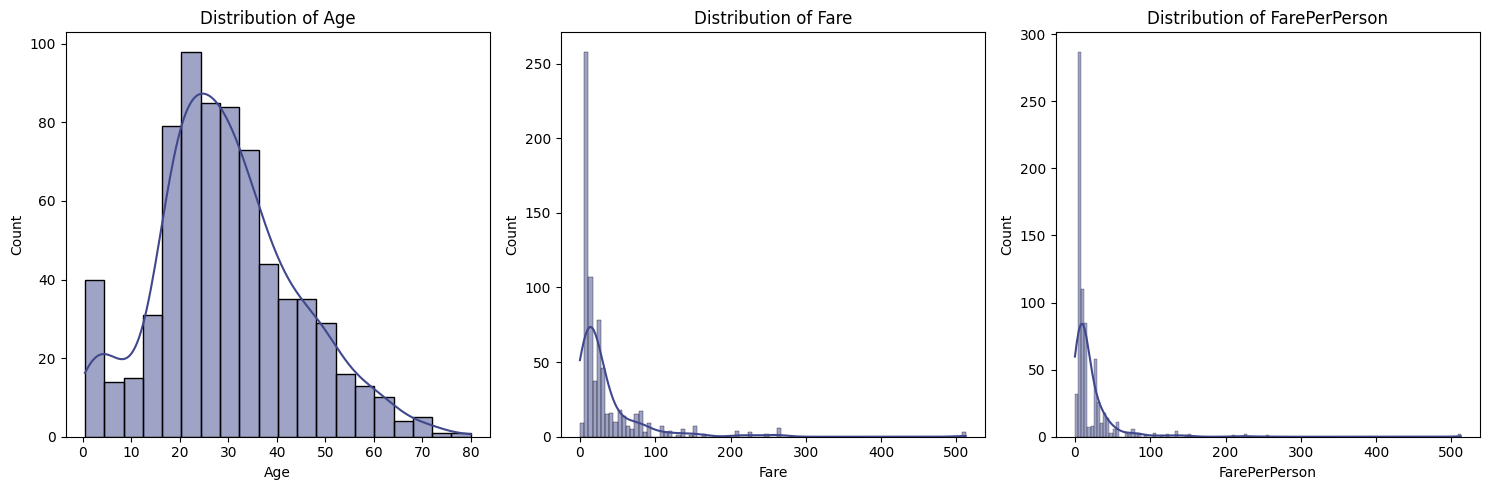

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(["Age", "Fare", "FarePerPerson"]):
    sns.histplot(pd.merge(X_train, y_train, on="PassengerId", how="left")[col], kde=True, ax=axes[i], color=mako(0.33))
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

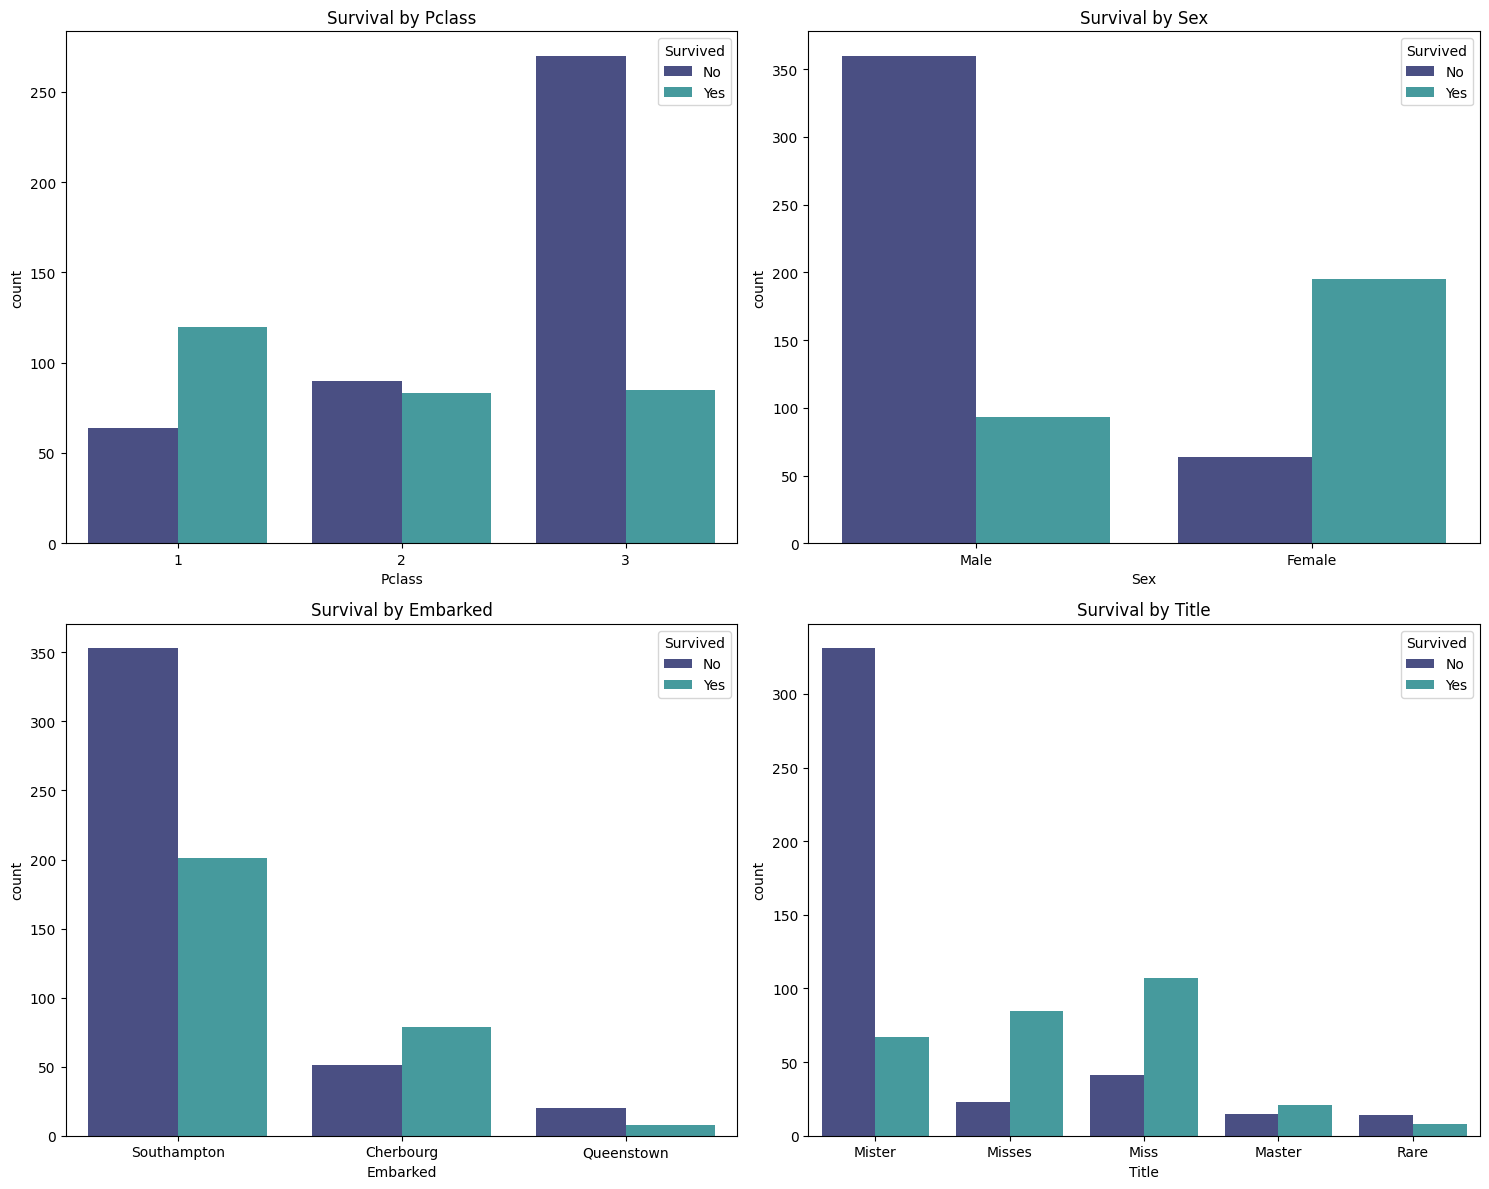

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
categories = ["Pclass", "Sex", "Embarked", "Title"]
for i, col in enumerate(categories):
    sns.countplot(x=col, hue="Survived", data=pd.merge(X_train, y_train, on="PassengerId", how="left"),
                  ax=axes[i//2, i%2], palette=[mako(0.33), mako(0.66)])
    axes[i//2, i%2].set_title(f"Survival by {col}")
    axes[i//2, i%2].legend(title="Survived", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

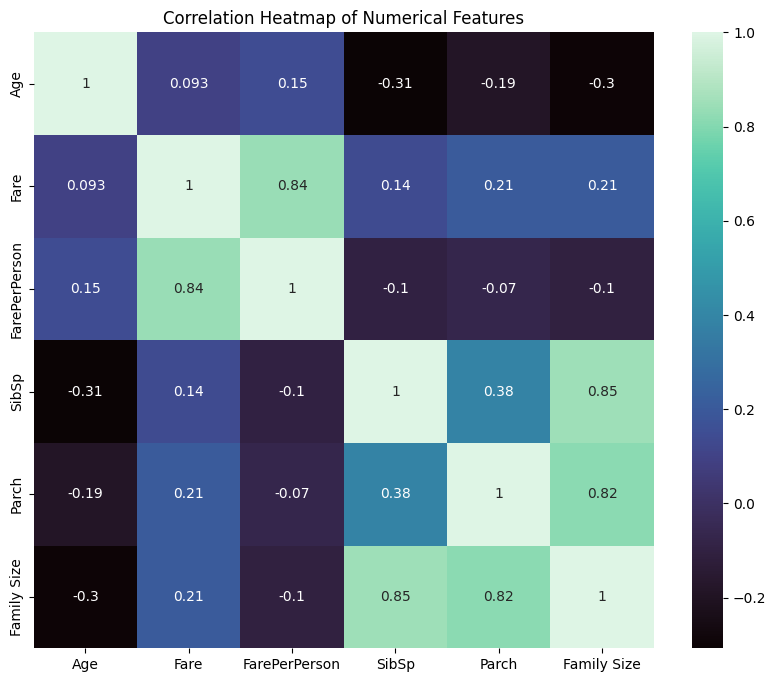

In [61]:
corr = X_train[['Age', 'Fare', 'FarePerPerson', 'SibSp', 'Parch', 'Family Size']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap=cmap)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

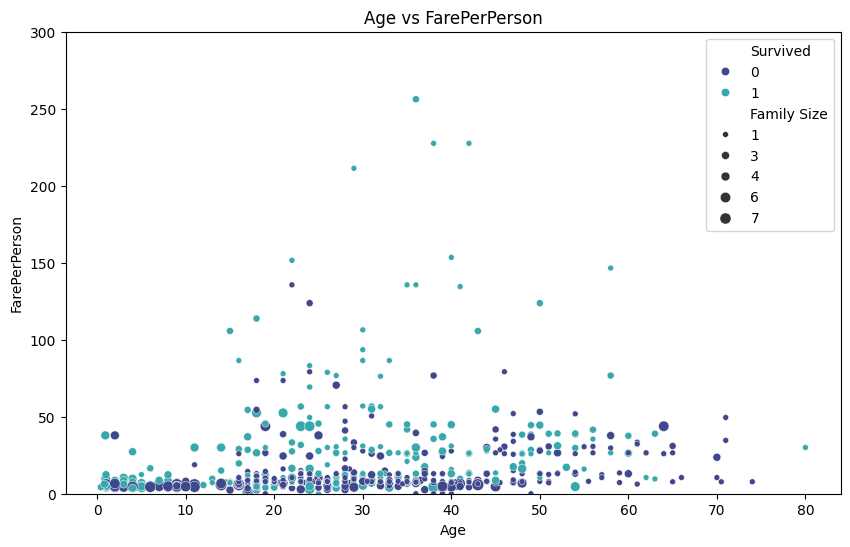

In [68]:
plt.figure(figsize=(10, 6))
fig = sns.scatterplot(x='Age', y='FarePerPerson', hue='Survived', size='Family Size',
                data=pd.merge(X_train, y_train, on="PassengerId", how="left"),
                palette=[mako(0.33), mako(0.66)])
fig.set_ylim(0, 300)
plt.title('Age vs FarePerPerson')
plt.show()

### Data Pre-Processing

In [66]:
X_train.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Family Size', 'Title', 'Age Group', 'FarePerPerson'],
      dtype='object')

In [75]:
numeric_features = ["Age", "SibSp", "Parch", "Fare", "Family Size", "FarePerPerson"]
categorical_features = ["Pclass", "Sex", "Embarked", "Title", "Age Group"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

### Analysis

##### Logistic Regression

##### Linear Discriminant Analysis

##### ElasticNet

##### Support Vector Machine

##### K-Nearest Neighbors

##### Naïve Bayes

##### Gaussian Process Classifier

##### Voting Classifier

##### Random Forests

##### XGBoost

##### CatBoost

##### Artifical Neural Network

### Conclusion